This Notebook contains the code used for predicting mortality within 3 year using the CatBoost model

In [ ]:
import os
import json
import numpy as np
import pandas as pd
from collections import Counter
import random
import cv2
from PIL import Image
import pickle
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import r2_score
from sklearn.metrics import roc_auc_score,roc_curve,auc
from sklearn.preprocessing import label_binarize
from sklearn import metrics
from sklearn.utils.class_weight import compute_class_weight
from fancyimpute import IterativeImputer
from matplotlib import pyplot
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import sklearn
from sklearn.model_selection import GroupShuffleSplit

from sklearn.metrics import mean_squared_error,mean_absolute_error

from catboost import Pool, CatBoostClassifier
from catboost import CatBoostRegressor
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc

import torch.nn.functional as F
from torchvision import models
from torch import nn
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torch import optim

# Functions and Classes

In [42]:
def print_multi_confusion_matrix(actual_class, pred_class,target_names):
    df_array  = confusion_matrix(actual_class, pred_class)
    df_cm = pd.DataFrame(df_array, index = [i for i in ["T_" + x for x in target_names]],
                      columns = [i for i in ["P_" + x for x in target_names]])
    plt.figure(figsize = (7,7))
    plt.title("Confusion Matrix")
    plt.xlabel('Target Lvef')
    plt.ylabel('Predicted Lvef')
    sn.heatmap(df_cm, annot=True,fmt=".1f")
    sn.set(font_scale=1) 
    print(classification_report(actual_class , pred_class, target_names=target_names))

In [43]:
def get_3_class_names(y_data):
    y_class_names = []
    for i in range(len(y_data)):
        if(y_data[i]==0):
            y_class_names.append("no_change")
        elif (y_data[i]==1):
            y_class_names.append("Decrease")
        elif (y_data[i]==2):
            y_class_names.append("Increase")  
    return y_class_names

In [44]:
def get_frames_from_video(filename, n_frames= 1):
    frames = []
    v_cap = cv2.VideoCapture(filename) #open the video file
    v_len = int(v_cap.get(cv2.CAP_PROP_FRAME_COUNT))  #passing the respective property name into the .get method of the video pointer will allow us to obtain the total number of frames in the video 
    frame_list= np.linspace(0, v_len-1, n_frames, dtype=np.int16)
    all_frames = []
    for fn in range(v_len):
        success, frame = v_cap.read() #reades every frame if the frames are over it will go to the next video
        if success is False:
            continue
        all_frames.append(frame)
        if (fn in frame_list):
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)  
            frames.append(frame)
    v_cap.release()
    return frames

In [45]:
class MortalityNetVideoClass(nn.Module):
    def __init__(self,resnetmodel):
        super().__init__()

        self.features_conv = nn.Sequential(
            resnetmodel.stem,
            resnetmodel.layer1,
            resnetmodel.layer2,
            resnetmodel.layer3,
            resnetmodel.layer4,
        )
        self.averagepool = resnetmodel.avgpool
        self.fc3 = nn.Linear(512, 2)
        self.relu = nn.ReLU()
        self.video_features1 = 0
        self.video_features2 = 0
        #self.fc5 = nn.Linear(100, 2)  #lvef,lesv
        self.gradients = None
        self.base_gradients = None
 
    def forward(self, x1):
        
        x = self.features_conv(x1)
        
        if x.requires_grad:
            h = x.register_hook(self.activations_hook)
        
        x11 = self.averagepool(x)
        x11 = x11.flatten(1)
        x = self.fc3(x11)       
        return x
    
    def activations_hook(self, grad):
        self.gradients = grad
        
    def get_activations_gradient(self):
        return self.gradients
    
    def get_features_gradients(self):
        return self.base_gradients
    
    def get_activations(self, x):
        return self.features_conv(x)
    
    def getpooledfeatures(self,x):
        x = self.features_conv(x)
        x = self.averagepool(x)
        x = x.flatten(1)
        return x
    
    
    def features_hook(self, grad):
        self.base_gradients = grad

In [46]:
def get_auc_curve(y_test, probs):
    fpr, tpr, threshold = roc_curve(y_test, probs)
    return fpr,tpr,threshold

def plot_auc_curve(fpr,tpr,roc_auc):
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

In [47]:
def get_best_threshold(y_true, y_pred, thresholds):
    best_threshold = 0.5
    best_youden_index = 0
    for t in thresholds:
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred > t).ravel()
        sensitivity = tp / (tp + fn)
        specificity = tn / (tn + fp)
        youden_index = sensitivity + specificity - 1
        if youden_index > best_youden_index:
            best_youden_index = youden_index
            best_threshold = t
    print(f"Best YD index : {best_youden_index } ")
    print(f"best threshold : {best_threshold}")
    return best_threshold

In [48]:
def plot_roc_multi(y_true, y_probas,class_labels, title='ROC Curves',
                   plot_micro=True, plot_macro=True, classes_to_plot=None,
                   ax=None, figsize=None, cmap='nipy_spectral',
                   title_fontsize="large", text_fontsize="medium"):
    y_true = np.array(y_true)
    y_probas = np.array(y_probas)

    classes = np.array(class_labels)
    probas = y_probas

    if classes_to_plot is None:
        classes_to_plot = classes

    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=figsize)

    ax.set_title(title, fontsize=title_fontsize)

    fpr_dict = dict()
    tpr_dict = dict()

    indices_to_plot = np.in1d(classes, classes_to_plot)
    for i, to_plot in enumerate(indices_to_plot):
        fpr_dict[i], tpr_dict[i], _ = roc_curve(y_true, probas[:, i],
                                                pos_label=classes[i])
        if to_plot:
            roc_auc = auc(fpr_dict[i], tpr_dict[i])
            color = plt.cm.get_cmap(cmap)(float(i) / len(classes))
            ax.plot(fpr_dict[i], tpr_dict[i], lw=2, color=color,
                    label='ROC curve of class {0} (area = {1:0.2f})'
                          ''.format(classes[i], roc_auc))

    if plot_micro:
        binarized_y_true = label_binarize(y_true, classes=classes)
        if len(classes) == 2:
            binarized_y_true = np.hstack(
                (1 - binarized_y_true, binarized_y_true))
        fpr, tpr, _ = roc_curve(binarized_y_true.ravel(), probas.ravel())
        roc_auc = auc(fpr, tpr)
        ax.plot(fpr, tpr,
                label='micro-average ROC curve '
                      '(area = {0:0.2f})'.format(roc_auc),
                color='deeppink', linestyle=':', linewidth=4)
    micro_auc = roc_auc
    
    if plot_macro:
        # Compute macro-average ROC curve and ROC area
        # First aggregate all false positive rates
        all_fpr = np.unique(np.concatenate([fpr_dict[x] for x in range(len(classes))]))

        # Then interpolate all ROC curves at this points
        mean_tpr = np.zeros_like(all_fpr)
        for i in range(len(classes)):
            mean_tpr += np.interp(all_fpr, fpr_dict[i], tpr_dict[i])

        # Finally average it and compute AUC
        mean_tpr /= len(classes)
        roc_auc = auc(all_fpr, mean_tpr)

        ax.plot(all_fpr, mean_tpr,
                label='macro-average ROC curve '
                      '(area = {0:0.2f})'.format(roc_auc),
                color='navy', linestyle=':', linewidth=4)
    macro_auc = roc_auc

    ax.plot([0, 1], [0, 1], 'k--', lw=2)
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate', fontsize=text_fontsize)
    ax.set_ylabel('True Positive Rate', fontsize=text_fontsize)
    ax.tick_params(labelsize=text_fontsize)
    ax.legend(loc='lower right', fontsize=text_fontsize)
    return ax,micro_auc,macro_auc

In [49]:
def get_3class(first_visit,y_test, pred):
    Actual_change = ((y_test - first_visit)/first_visit)*100
    pred_change = ((pred - first_visit)/first_visit)*100
    pred_class = []
    for change in pred_change:
        if(change<-5):
            pred_class.append(1)
        elif(change>5):
            pred_class.append(2)
        else:
            pred_class.append(0)

    actual_class = []
    for change in Actual_change:
        if(change<-5):
            actual_class.append(1)
        elif(change>5):
            actual_class.append(2)
        else:
            actual_class.append(0)
    return pred_class,actual_class

In [50]:
def get_class_names(y_data):
    y_class_names = []
    for i in range(len(y_data)):
        if(y_data[i]==0):
            y_class_names.append("Alive")
        elif (y_data[i]==1):
            y_class_names.append("Dead")
    return y_class_names

In [51]:
def make_confusion_matrix(actual_class , Pred , target_names, title ,cutoff=None):
    df_array  = confusion_matrix(actual_class, Pred>cutoff)
    df_cm = pd.DataFrame(df_array, index = [i for i in ["T_" + x for x in target_names]],
                      columns = [i for i in ["P_" + x for x in target_names]])
    plt.figure(figsize = (7,7))
    plt.title("Confusion Matrix")
    plt.xlabel('Target Mortality')
    plt.ylabel('Predicted Mortality')
    sn.heatmap(df_cm, annot=True,fmt=".1f")
    sn.set(font_scale=1) 
    print(classification_report(actual_class, Pred>cutoff, target_names=target_names))

In [52]:
def cudaalloc():
  nvmlInit()
  h = nvmlDeviceGetHandleByIndex(0)
  info = nvmlDeviceGetMemoryInfo(h)
  print(f'total    : {(info.total)/1000000000} GB')
  print(f'free     : {(info.free)/1000000000} GB')
  print(f'used     : {(info.used)/1000000000} GB')

In [53]:
def estimate_coef(x, y):
    # number of observations/points
    n = np.size(x)
 
    # mean of x and y vector
    m_x = np.mean(x)
    m_y = np.mean(y)
 
    # calculating cross-deviation and deviation about x
    SS_xy = np.sum(y*x) - n*m_y*m_x
    SS_xx = np.sum(x*x) - n*m_x*m_x
 
    # calculating regression coefficients
    b_1 = SS_xy / SS_xx
    b_0 = m_y - b_1*m_x
 
    return (b_0, b_1)

def plot_regression_line(x, y, b):
    # plotting the actual points as scatter plot
    plt.scatter(x, y, color = "green",
               marker = "o", s = 30)
 
    # predicted response vector
    y_pred = b[0] + b[1]*x
 
    # plotting the regression line
    plt.plot(x, y_pred, color = "red")
 
    # putting labels
    plt.title("Scatter plot for regression")
    plt.xlabel("Target LVEF")
    plt.ylabel("Predicted LVEF")
    # function to show plot
    plt.show()
    
def bland_altman_plot(data1, data2, *args, **kwargs):
    data1     = np.asarray(data1)
    data2     = np.asarray(data2)
    mean      = np.mean([data1, data2], axis=0)
    diff      = data1 - data2                   # Difference between data1 and data2
    md        = np.mean(diff)                   # Mean of the difference
    sd        = np.std(diff, axis=0)            # Standard deviation of the difference

    plt.scatter(mean, diff, *args, **kwargs)
    plt.axhline(md,           color='gray', linestyle='--')
    plt.axhline(md + 1.96*sd, color='gray', linestyle='--')
    plt.axhline(md - 1.96*sd, color='gray', linestyle='--')
    plt.title("Bland–Altman plot")
    plt.xlabel("Average of the 2 values")
    plt.ylabel("Difference between predicted and actual LVEF values")
    plt.show()

# Mortality

## External Validation

### Data_Creation

In [17]:
#load the data that contains the info and features about patients for the 3 year timeline
Dataframe = pd.read_csv('Generated_csv_files/Mackay_mortality_within_1095_days.csv')

In [18]:
len(columns_to_train)

18

In [19]:
columns_to_train = ['Ivs',
                    'Lvpw',
                    'Lvidd',
                    'Lvids',
                    'Lvedv',
                    'Lvesv',
                    'Hr',
                    'Dt',
                    'Ivrt',
                    'E',
                    'A',
                    'TDI_e_lateral',
                    'TDI_e_septal',
                    'gender',
                    'age',
                    'LA_MAX_VOLUME',
                    'TR_VELOCITY',
                    'Ef']
get_features = columns_to_train

In [20]:
Dataframe = Dataframe.sort_values(by=['PatientID','ExamDate']).reset_index(drop=True)
Dataframe['gender'] = Dataframe['gender'].fillna("Male")
for col in columns_to_train:
    if(col=='gender'):
        continue
    Dataframe[col] = pd.to_numeric(Dataframe[col],errors='coerce')
Dataframe = Dataframe.sample(frac = 1, random_state=42)
Dataframe = Dataframe.drop_duplicates(subset='PatientID', keep="last").reset_index()
Dataframe = Dataframe.sort_values(by=['PatientID','ExamDate']).reset_index(drop=True)

In [21]:
len(Dataframe.loc[Dataframe['mortality']==1]['PatientID']) , len(Dataframe.loc[Dataframe['mortality']==0])

(839, 2098)

<b> For External Validation

In [22]:
X_data = Dataframe[columns_to_train]
y_data = Dataframe[['mortality']]
y_class = Dataframe[['mortality']]
skf = StratifiedShuffleSplit(test_size=.10, n_splits=2, random_state = 1369)
train_inds, test_inds = next(skf.split(X_data, y_data))

X_train = Dataframe.iloc[train_inds][get_features].values
y_train = Dataframe.iloc[train_inds]['mortality'].values

X_test_dataframe = Dataframe.iloc[test_inds].reset_index(drop=True)
X_test = X_test_dataframe[get_features].values
y_test = Dataframe.iloc[test_inds]['mortality'].values

X_val = X_test_dataframe[get_features].values
y_val = Dataframe.iloc[test_inds]['mortality'].values

In [23]:
#print("the overlapping pids are", len(set(X_train_pid).intersection(set(X_test_pid))))
#print("the overlapping pids are", len(set(X_train_pid).intersection(set(X_test_pid).intersection(X_val_pid))))
print(len(X_train),len(X_val),len(X_test))

2643 294 294


### Grid Search and External Training

In [24]:
class_weights = compute_class_weight('balanced',classes = np.unique(y_train),y = y_train)
print(class_weights)
model = CatBoostClassifier(loss_function='Logloss',class_weights= class_weights , class_names=[0,1],logging_level='Silent')

train_dataset = Pool(X_train,
                     y_train,cat_features=[13])

grid = {'iterations': [200, 400, 600,1000],
        'learning_rate': [0.03, 0.005,0.0005],
        'depth': [2, 4, 6, 8],
        'l2_leaf_reg': [1,2,3,4,5]}
grid_search_result = model.grid_search(grid, train_dataset,cv=5, verbose=False,plot=True)

[0.69994703 1.75033113]


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [25]:
grid_search_result['params']

{'depth': 4, 'l2_leaf_reg': 4, 'iterations': 600, 'learning_rate': 0.03}

In [26]:
class_weights = compute_class_weight('balanced',classes = np.unique(y_train),y = y_train)
print(class_weights)
model = CatBoostClassifier(iterations=grid_search_result['params']['iterations'], 
                           task_type="CPU",learning_rate=grid_search_result['params']['learning_rate'],random_seed=0,use_best_model=True,
                          early_stopping_rounds=100,depth=grid_search_result['params']['depth'],loss_function='Logloss',l2_leaf_reg=grid_search_result['params']['l2_leaf_reg'],class_weights= class_weights , class_names=[0,1])
train_dataset = Pool(X_train,
                     y_train,cat_features=[13] )
eval_dataset = Pool(X_val,y_val,cat_features=[13])
model.fit(train_dataset,
          use_best_model=True,
          eval_set=eval_dataset,verbose=False,plot=True)
print(len(X_train),len(X_val),len(X_test))

[0.69994703 1.75033113]


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

2643 294 294


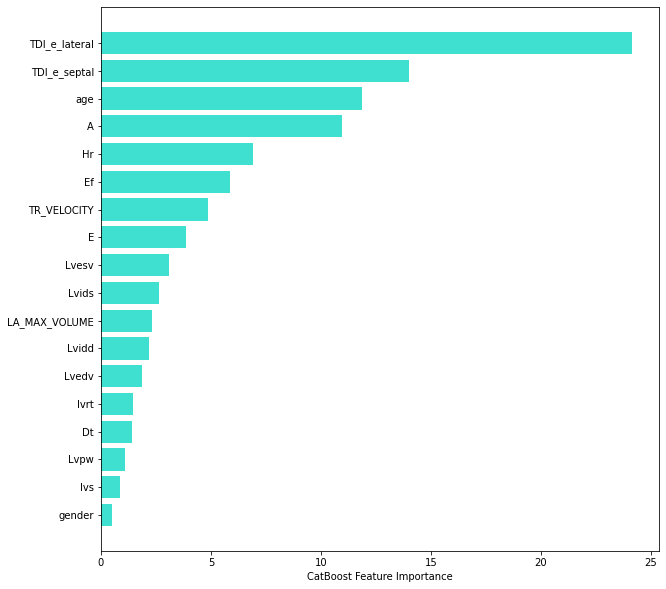

In [28]:
get_features = np.array(get_features)
data = pd.DataFrame({'feature_importance': model.get_feature_importance(train_dataset ), 
              'feature_names': get_features}).sort_values(by=['feature_importance'], 
                                                       ascending=False)
sorted_feature_importance = model.feature_importances_.argsort()
plt.figure(figsize=(10,10))
plt.barh(get_features[sorted_feature_importance], 
        model.feature_importances_[sorted_feature_importance], 
        color='turquoise')
plt.xlabel("CatBoost Feature Importance")
plt.savefig('feature.png', bbox_inches='tight',pad_inches = 0)
plt.show()

In [82]:
path = "model/catboost/Mackay_1095days_External_Catboost.cbm"
model.save_model(path,
           format="cbm",
           export_parameters=None,
           pool=None)

### External Validation

In [68]:
columns_to_train = ['Ivs',
                    'Lvpw',
                    'Lvidd',
                    'Lvids',
                    'Lvedv',
                    'Lvesv',
                    'Hr',
                    'Dt',
                    'Ivrt',
                    'E',
                    'A',
                    'TDI_e_lateral',
                    'TDI_e_septal',
                    'gender',
                    'age',
                    'LA_MAX_VOLUME',
                    'TR_VELOCITY',
                    'Ef']
get_features = columns_to_train

In [69]:
model = CatBoostClassifier()
model.load_model("models/catboost/Mackay_1095days_External_Catboost.cbm")

In [70]:
Dataframe = pd.read_csv('Generated_csv_files/Mackay_mortality_within_1095_days.csv')
Dataframe = Dataframe.sort_values(by=['PatientID','ExamDate']).reset_index(drop=True)
Dataframe['gender'] = Dataframe['gender'].fillna("Male")
for col in columns_to_train:
    if(col=='gender'):
        continue
    Dataframe[col] = pd.to_numeric(Dataframe[col],errors='coerce')
Dataframe = Dataframe.sample(frac = 1, random_state=42)
Dataframe = Dataframe.drop_duplicates(subset='PatientID', keep="last").reset_index()
Dataframe = Dataframe.sort_values(by=['PatientID','ExamDate']).reset_index(drop=True)

In [71]:
len(Dataframe.loc[Dataframe['mortality']==1]['PatientID']) , len(Dataframe.loc[Dataframe['mortality']==0])

(839, 2098)

In [72]:
X_test = Dataframe[get_features].values
y_test = Dataframe['mortality'].values
y_test_class = Dataframe['mortality'].values

In [73]:
Pred_class = model.predict(X_test)
y_Mackay_test_class = y_test
pred_prob_Mackay = model.predict_proba(X_test)

pred_prob_Mackay = np.array(pred_prob_Mackay)
y_Mackay_test_class = np.array(y_Mackay_test_class)
fpr, tpr,t = get_auc_curve(y_Mackay_test_class,pred_prob_Mackay[:, 1])

external_cutoff = get_best_threshold(y_Mackay_test_class, pred_prob_Mackay[:, 1], t)

Best YD index : 0.6996924251600083 
best threshold : 0.5102096634833599


In [74]:
root = "../AlbertaHeart/"
External_Dataframe = pd.read_csv(root + 'Generated_csv_files/Alberta_mortality_1095_days.csv')
External_Dataframe = External_Dataframe.rename(columns={"StudyNumber":"PatientID", "PLAX_video_path":"PLAX_video_id"})
External_Dataframe = External_Dataframe.drop(['Unnamed: 0','Obs'],axis=1)
External_Dataframe = External_Dataframe.sample(frac = 1, random_state=42)
External_Dataframe = External_Dataframe.drop_duplicates(subset='PatientID', keep="last").reset_index()
External_Dataframe['IVSdcm'] = External_Dataframe['IVSdcm']*10
External_Dataframe['LVPWdcm'] = External_Dataframe['LVPWdcm']*10
External_Dataframe['LVIDdcm'] = External_Dataframe['LVIDdcm']*10
External_Dataframe = External_Dataframe.rename(columns=
                          {"IVSdcm": "Ivs", 
                           "LVPWdcm": "Lvpw",
                          "LVIDdcm":"Lvidd",
                          "LVIDscm":"Lvids",
                          "LVEDV MOD Bip (mL)":"Lvedv",
                          "LVESV MOD Bip (mL)":"Lvesv",
                          "heart_rate":"Hr",
                          "Decelerationms":"Dt",
                          "IVRTms":"Ivrt",
                          "MV-E (cm/sec)":"E",
                          "MV-A (cm/sec)":"A",
                          "PWTDI e\' lateral":"TDI_e_lateral",
                          "PWTDI e\' septal":"TDI_e_septal",
                           "Gender":"gender",
                          "AgeatEnrollment":"age",
                           "LVEF":"Ef",
                          "LAVolume2Dml":"LA_MAX_VOLUME",
                          "TrVmax m/sec":"TR_VELOCITY"})
features = columns_to_train

for col in columns_to_train:
    if(col=='gender'):
        continue
    External_Dataframe[col] = pd.to_numeric(External_Dataframe[col],errors='coerce')

External_Dataframe = External_Dataframe.replace(r'^\s*$', np.nan, regex=True)

In [75]:
X_test = External_Dataframe[get_features].values

y_test = External_Dataframe['mortality'].values
y_test_class = External_Dataframe['mortality'].values

              precision    recall  f1-score   support

       Alive       0.91      0.95      0.93       534
        Dead       0.24      0.15      0.18        61

    accuracy                           0.86       595
   macro avg       0.57      0.55      0.55       595
weighted avg       0.84      0.86      0.85       595



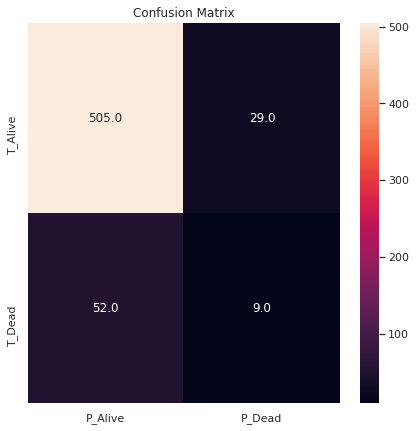

In [76]:
Pred_class = model.predict(X_test)
Actual_class = y_test
preds_proba = model.predict_proba(X_test)
print_multi_confusion_matrix(Actual_class,Pred_class,target_names=["Alive","Dead"])
y_test_class_names = get_class_names(y_test)
#plot_roc_multi(y_test_class_names,preds_proba ,class_labels = ["Alive","Dead"],figsize=(6,6))
plt.show()

In [77]:
pred_prob = np.array(preds_proba)
data = {'Target':Actual_class,
        'Pred':Pred_class,
       'Prob':pred_prob[:, 1]}
df = pd.DataFrame(data)

In [78]:
df.to_csv('Generated_csv_files/Cat_1095.csv')

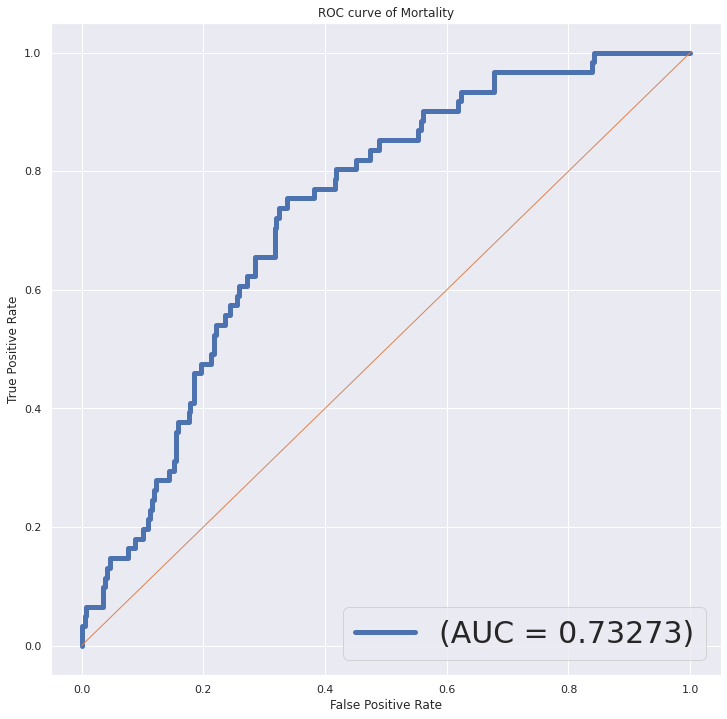

In [79]:
class_names=["Alive","Dead"]
y_test_class_names = get_class_names(y_test)
y_test_class = label_binarize(np.array(y_test_class_names),classes=class_names)
pred_prob = np.array(preds_proba)
y_test_class = np.array(y_test_class)
fpr, tpr,t = get_auc_curve(y_test_class,pred_prob[:, 1])
roc_auc = auc(fpr, tpr)
fig1 = plt.figure(figsize=[12,12])
plt.plot(fpr, tpr, lw=5, alpha=1, label='(AUC = %0.5f)' % (roc_auc))
plt.plot(np.linspace(0,1,len(fpr)), np.linspace(0,1,len(fpr)), lw=1, alpha=1 )
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve of Mortality')
plt.legend(loc="lower right",prop={'size': 30})
plt.show()

Best YD index : 0.4024989255234237 
best threshold : 0.07774600802201868
              precision    recall  f1-score   support

       Alive       0.91      0.95      0.93       534
        Dead       0.24      0.15      0.18        61

    accuracy                           0.87       595
   macro avg       0.58      0.55      0.56       595
weighted avg       0.84      0.87      0.85       595



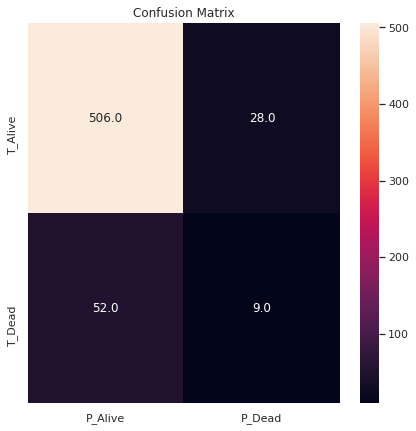

In [80]:
cutoff = get_best_threshold(y_test_class, pred_prob[:, 1], t)
make_confusion_matrix(y_test_class, pred_prob[:, 1],["Alive","Dead"],"Mortality classes",external_cutoff)

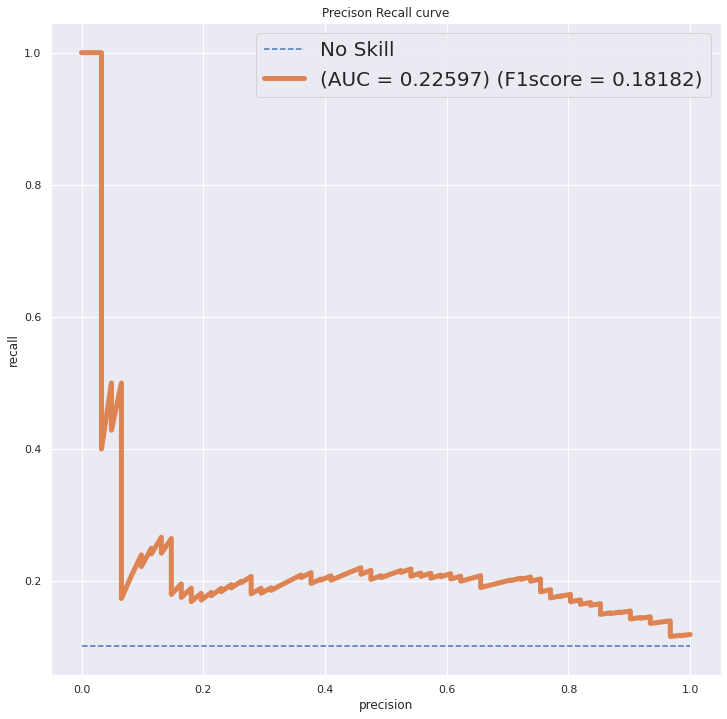

In [81]:
fig1 = plt.figure(figsize=[12,12])
F1score = f1_score(Actual_class,Pred_class)
precision, recall, thresholds = precision_recall_curve(y_test_class,pred_prob[:, 1])
auc_score = auc(recall, precision)
no_skill = len(y_test_class[y_test_class==1]) / len(y_test_class)
pyplot.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
plt.plot(recall, precision,lw=5, alpha=1, label='(AUC = %0.5f) (F1score = %0.5f)' % (auc_score, F1score))

plt.xlabel('precision')
plt.ylabel('recall')
plt.title('Precison Recall curve')
plt.legend(loc="upper right",prop={'size': 20})
plt.show()

In [82]:
test_dataset = Pool(X_test,
                     y_test,cat_features=[13])

In [ ]:
get_features = np.array(get_features)
data = pd.DataFrame({'feature_importance': model.get_feature_importance(test_dataset ,type="LossFunctionChange"), 
              'feature_names': get_features}).sort_values(by=['feature_importance'], 
                                                       ascending=False)
sorted_feature_importance = model.feature_importances_.argsort()
plt.figure(figsize=(10,10))
plt.barh(get_features[sorted_feature_importance], 
        model.feature_importances_[sorted_feature_importance], 
        color='turquoise')
plt.xlabel("CatBoost Feature Importance")
plt.savefig('feature.png', bbox_inches='tight',pad_inches = 0)
plt.show()

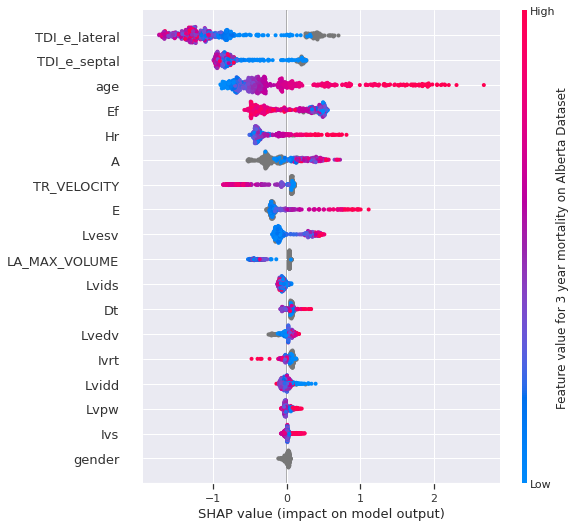

In [84]:
import shap
get_features = np.array(get_features)
data =  model.get_feature_importance(test_dataset ,type="ShapValues")
shap_values = data[:,:-1]

shap.summary_plot(shap_values, features = X_test, feature_names=get_features, color_bar_label='Feature value for 3 year mortality on Alberta Dataset') 

In [85]:
vals= np.abs(shap_values).mean(0)
feature_importance = pd.DataFrame(list(zip(get_features,vals)),columns=['col_name','feature_importance_vals'])
feature_importance.sort_values(by=['feature_importance_vals'],ascending=False,inplace=True)
feature_importance

,col_name,feature_importance_vals
11,TDI_e_lateral,1.059228
12,TDI_e_septal,0.730507
14,age,0.599895
17,Ef,0.363263
6,Hr,0.338650
10,A,0.242715
16,TR_VELOCITY,0.242532
9,E,0.217662
5,Lvesv,0.201789
15,LA_MAX_VOLUME,0.190866


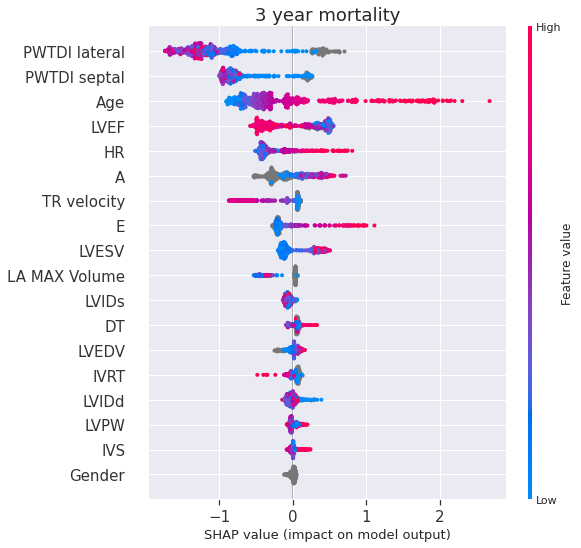

In [89]:
get_features[0] = "IVS"
get_features[1] = "LVPW"
get_features[2] = "LVIDd"
get_features[3] = "LVIDs"
get_features[4] = "LVEDV"
get_features[5] = "LVESV"
get_features[6] = "HR"
get_features[7] = "DT"
get_features[8] = "IVRT"
get_features[11] = "PWTDI lateral"
get_features[12] = "PWTDI septal"
get_features[13] = "Gender"
get_features[14] = "Age"
get_features[15] = "LA MAX Volume"
get_features[16] = "TR velocity"
get_features[17] = "LVEF"
explainer = shap.Explainer(model,feature_perturbation="tree_path_dependent")
shap_values = explainer(X_test)
shap_values.feature_names = np.array(get_features)
#fig = shap.plots.beeswarm(shap_values,max_display=20,order=np.arange(0,18),show=False)
fig = shap.plots.beeswarm(shap_values,max_display=20,show=False,color_bar_label='Feature value')
plt.title("3 year mortality",fontsize=18)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.savefig('3year_SHAP.png', dpi=100,pad_inches=0,bbox_inches = "tight")

## 5 fold cross Validation

### Training 5 fold

In [90]:
columns_to_train = ['Ivs',
                    'Lvpw',
                    'Lvidd',
                    'Lvids',
                    'Lvedv',
                    'Lvesv',
                    'Hr',
                    'Dt',
                    'Ivrt',
                    'E',
                    'A',
                    'TDI_e_lateral',
                    'TDI_e_septal',
                    'gender',
                    'age',
                    'LA_MAX_VOLUME',
                    'TR_VELOCITY',
                    'Ef']

In [91]:
Dataframe = pd.read_csv('Generated_csv_files/Mackay_mortality_within_1095_days.csv')
Dataframe = Dataframe.sort_values(by=['PatientID','ExamDate']).reset_index(drop=True)
Dataframe['gender'] = Dataframe['gender'].fillna("Male")
for col in columns_to_train:
    if(col=='gender'):
        continue
    Dataframe[col] = pd.to_numeric(Dataframe[col],errors='coerce')
    
Dataframe = Dataframe.sample(frac = 1, random_state=42)
Dataframe = Dataframe.drop_duplicates(subset='PatientID', keep="last").reset_index()
Dataframe = Dataframe.sort_values(by=['PatientID','ExamDate']).reset_index(drop=True)

#removing the columns that have more than 70% null values as it was difficult to do mice imputation using that
get_features = columns_to_train
X_data = Dataframe[get_features].values
y_data = Dataframe[['mortality']].values

skf = StratifiedShuffleSplit(test_size=.10, n_splits=5, random_state = 42)
train_inds, test_inds = next(skf.split(X_data, y_data))

X_train_dataframe = Dataframe.iloc[train_inds].reset_index(drop=True)
X_train_data = X_train_dataframe[get_features].values
y_train_data = Dataframe.iloc[train_inds]['mortality'].values

X_test_dataframe = Dataframe.iloc[test_inds].reset_index(drop=True)
X_test = X_test_dataframe[get_features].values
y_test = Dataframe.iloc[test_inds]['mortality'].values
y_test_class = Dataframe.iloc[test_inds]['mortality'].values
X_test_pid = Dataframe.iloc[test_inds]['PatientID'].values


In [ ]:
fold = 5
count = 1
skf = StratifiedShuffleSplit(test_size=.10, n_splits=fold, random_state = 42)
for train_inds, val_inds in skf.split(X_train_data, y_train_data):
    print("*"*10, "fold " , count, "*"*10)
    
    X_train_df = X_train_dataframe.iloc[train_inds].reset_index(drop=True)
    X_train = X_train_dataframe.iloc[train_inds][get_features].values
    y_train = X_train_dataframe.iloc[train_inds]['mortality'].values
    X_train_pid = X_train_dataframe.iloc[train_inds]['PatientID'].values

    X_val_df = X_train_dataframe.iloc[val_inds].reset_index(drop=True)
    X_val = X_train_dataframe.iloc[val_inds][get_features].values
    y_val = X_train_dataframe.iloc[val_inds]['mortality'].values
    X_val_pid = X_train_dataframe.iloc[val_inds]['PatientID'].values
    #dataframe definition
    trainlist = {}
    vallist = {}
    testlist = {}
    #sanity check overalaping pid in train and test is
    print("the overlapping pids are", len(set(X_train_pid).intersection(set(X_test_pid).intersection(X_val_pid))))
    print(len(X_test), len(X_train), len(X_val), len(X_test) + len(X_train_data), len(Dataframe))
    
    #Hyperparameter tuning
    class_weights = compute_class_weight('balanced',classes = np.unique(y_train),y = y_train)
    print(class_weights)
    
    model = CatBoostClassifier(loss_function='Logloss',class_weights= class_weights , class_names=[0,1],logging_level='Silent')

    train_dataset = Pool(X_train,
                         y_train,cat_features=[13])

    grid = {'iterations': [200, 400, 600,1000],
            'learning_rate': [0.03, 0.005,0.0005],
            'depth': [2, 4, 6, 8],
            'l2_leaf_reg': [1,2,3,4,5]}
    
    grid_search_result = model.grid_search(grid, train_dataset,cv=5, verbose=False,plot=True)
    print("grid search results are " , grid_search_result['params'])
    
    model = CatBoostClassifier(iterations=grid_search_result['params']['iterations'], 
                               task_type="CPU",learning_rate=grid_search_result['params']['learning_rate'],random_seed=0,use_best_model=True,
                              early_stopping_rounds=100,depth=grid_search_result['params']['depth'],loss_function='Logloss',l2_leaf_reg=grid_search_result['params']['l2_leaf_reg'],class_weights= class_weights , class_names=[0,1])
    
    train_dataset = Pool(X_train,
                         y_train,cat_features=[13] )
    
    eval_dataset = Pool(X_val,y_val,cat_features=[13])
    
    model.fit(train_dataset,
              use_best_model=True,
              eval_set=eval_dataset,verbose=False,plot=True)
    print(len(X_train),len(X_val),len(X_test))
    
    path = "models/catboost/fold_1095/Mackay_1095days_fold_" + str(count) + "_Catboost.cbm"
    model.save_model(path,
               format="cbm",
               export_parameters=None,
               pool=None)
    
    print("*"*20)
    count+=1

### Testing 5 fold

In [92]:
five_fold_results = {}
five_fold_results['Target'] = []
five_fold_results['Fold1'] = []

********** fold  1 **********
2643 294
Best YD index : 0.7364708440902459 
best threshold : 0.5218457639175109
Test cutoff matrix
Best YD index : 0.6833333333333333 
best threshold : 0.2721920541694494
              precision    recall  f1-score   support

       Alive       0.92      0.78      0.85       210
        Dead       0.60      0.83      0.70        84

    accuracy                           0.80       294
   macro avg       0.76      0.81      0.77       294
weighted avg       0.83      0.80      0.80       294



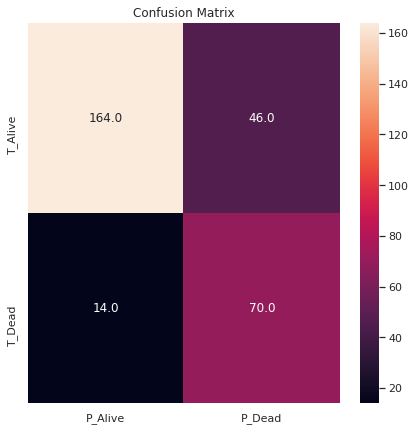

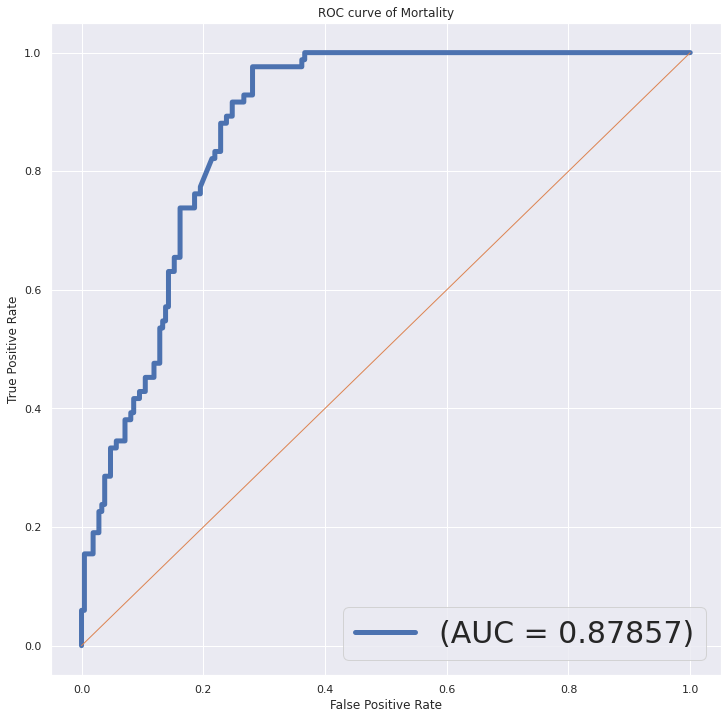

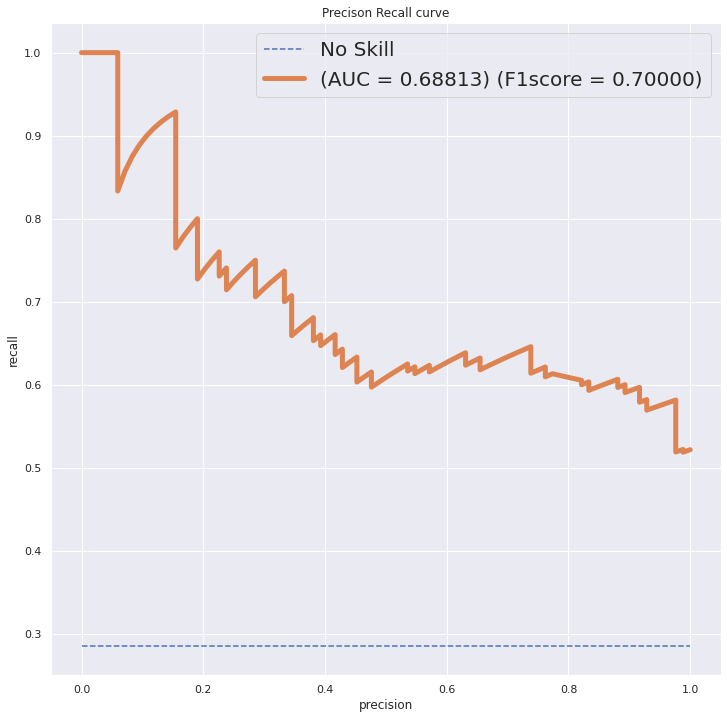

In [93]:
fold = 1
count = 1

for i in range(5):
    
    print("*"*10, "fold " , count, "*"*10)
    X_val_df = X_train_dataframe.reset_index(drop=True)
    X_val = X_train_dataframe[get_features].values
    y_val = X_train_dataframe['mortality'].values
    X_val_pid = X_train_dataframe['PatientID'].values
    #print("the overlapping pids are", len(set(X_train_pid).intersection(set(X_test_pid)).intersection(set(X_val_pid))))
    
    #model definitions
    print(len(X_val),len(X_test))
    model = CatBoostClassifier()
    path2models = "models/catboost/fold_1095/"
    model.load_model(path2models + "Mackay_1095days_fold_" + str(count) + "_Catboost.cbm")
    
    #getting the threshold values
    Pred_class_val = model.predict(X_val)
    Actual_class_val = y_val
    preds_prob_val = model.predict_proba(X_val)
    
    class_names=["Alive","Dead"]
    y_val_class_names = get_class_names(y_val)
    y_val_class = label_binarize(np.array(y_val_class_names),classes=class_names)
    pred_prob_val = np.array(preds_prob_val)
    y_val_class = np.array(y_val_class)
    fpr, tpr,t = get_auc_curve(y_val_class,pred_prob_val[:, 1])
    
    cutoff_from_val = get_best_threshold(y_val_class, pred_prob_val[:, 1], t)
    
    #testing the test set
    Pred_class = model.predict(X_test)
    Actual_class = y_test
    preds_proba = model.predict_proba(X_test)
    #print_multi_confusion_matrix(Actual_class,Pred_class,target_names=["Alive","Dead"])
    plt.show()
    five_fold_results['Target'] = y_test
    
    class_names=["Alive","Dead"]
    y_test_class_names = get_class_names(y_test)
    y_test_class = label_binarize(np.array(y_test_class_names),classes=class_names)
    pred_prob = np.array(preds_proba)
    y_test_class = np.array(y_test_class)
    fpr, tpr,t = get_auc_curve(y_test_class,pred_prob[:, 1])
    
    #print the confusion matrix using the cutt off from the train set
    print("Test cutoff matrix")
    cutoff_from_test = get_best_threshold(y_test_class, pred_prob[:, 1], t)
    make_confusion_matrix(y_test_class, pred_prob[:, 1],["Alive","Dead"],"Mortality classes",cutoff_from_val)
    
    roc_auc = auc(fpr, tpr)
    fig1 = plt.figure(figsize=[12,12])
    plt.plot(fpr, tpr, lw=5, alpha=1, label='(AUC = %0.5f)' % (roc_auc))
    plt.plot(np.linspace(0,1,len(fpr)), np.linspace(0,1,len(fpr)), lw=1, alpha=1 )
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve of Mortality')
    plt.legend(loc="lower right",prop={'size': 30})
    plt.show()
    
    
    fig1 = plt.figure(figsize=[12,12])
    F1score = f1_score(Actual_class,Pred_class)
    precision, recall, thresholds = precision_recall_curve(y_test_class,pred_prob[:, 1])
    auc_score = auc(recall, precision)
    no_skill = len(y_test_class[y_test_class==1]) / len(y_test_class)
    pyplot.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
    plt.plot(recall, precision,lw=5, alpha=1, label='(AUC = %0.5f) (F1score = %0.5f)' % (auc_score, F1score))

    plt.xlabel('precision')
    plt.ylabel('recall')
    plt.title('Precison Recall curve')
    plt.legend(loc="upper right",prop={'size': 20})
    plt.show()

    five_fold_results["Fold"+str(count)] = pred_prob
    count+=1
    break

In [94]:
data = {'Target':five_fold_results['Target'],
       'Prob':five_fold_results['Fold1'][:, 1]}
df = pd.DataFrame(data)

In [95]:
df.to_csv('Generated_csv_files/Cat_5fold_1095.csv')